<meta name="twitter:image" content="http://deeplearnphysics.org/Blog/imgs/2018-01-05-TrainingSegmentationData_v0.1.0/thumbnail.png" />

In this notebook I demonstrate training of a semantic segmentation algorithm for **separating track/shower particles at pixel level** using [practice samples in public data set](http://deeplearnphysics.org/DataChallenge/#TutorialSegmentation). To learn about this sample, or what the challenge is about, you might want to start from [**this post**](http://deeplearnphysics.org/Blog/2018-01-01-BrowsingSegmentationData_v0.1.0.html). Here's an outline.

0. [U-ResNet](#uresnet) (semantic segmentation network instance)
1. [IO configuration](#config)
2. [Training the net](#train)
3. [Training results/summary](#train_result)
3. Extra: [a bit more about U-ResNet](#uresnet_brief)

I usually write a _closing remark_ in my notebook. But in this one, I write it at the beginning because of a higher chance to be read by you :) If you have a question, comment or request regarding this notebook, softare or data used, please feel free to [contact us](mailto:contact@deeplearnphysics.org)! Your inputs are _super_ valuable. If you find softwares used in this notebook useful ([larcv](https://github.com/DeepLearnPhysics/larcv2), [u-resnet](https://github.com/DeepLearnPhysics/u-resnet)), please give stars! You can make us really happy by explicitly cheering us up :)

OK back to the business. Before anything, let's start with the basic (usual) imports.

In [1]:
import ROOT
from larcv import larcv
larcv.ThreadProcessor
from larcv.dataloader2 import larcv_threadio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os,sys,time

# tensorflow/gpu start-up configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
import tensorflow as tf

Welcome to ROOTaaS 6.06/06
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


<a name="uresnet"></a>
## U-ResNet
In this tutorial, we use **U-ResNet**, one type of convolutional neural networks for sematic segmentation task. It is developed/used within [MicroBooNE](http://microboone.fnal.gov) experiment. They showed a beautiful track/shower separation images on both data and simulation in [conferences](https://indico.fnal.gov/event/9942/timetable/#20170619). Below is a result of running a trained U-ResNet on real MicroBooNE detector data ([source](https://indico.fnal.gov/event/9942/session/4/contribution/68/material/slides/0.pdf)).
<table width="100%">
<tr>
<th><img src="imgs/2018-01-05-TrainingSegmentationData_v0.1.0/data.png"  alt="Data"></th>
<th><img src="imgs/2018-01-05-TrainingSegmentationData_v0.1.0/network.png"  alt="Network"></th>
</tr>
</table>

This work is originally implemented using [caffe](http://caffe.berkeleyvision.org) and the details are under preparation to be shared in public. However we made the network design available in our [group repository](https://github.com/DeepLearnPhysics/u-resnet) which is what we use in this notebook. **<font color="red">We do not describe the details of U-ResNet in this notebook</font>** (well, **only briefly at the [last section](#uresnet_brief)**). That should be documented in U-ResNet repository, and I might make a separate blog post for that. For now, just think of it as a generic semantic segmentation algorithm that can be trained for track/shower separation today.

Apology for a long preface! Let's pull the code first.

In [2]:
%%bash
if [ ! -d "u-resnet" ]; then
    git clone https://github.com/DeepLearnPhysics/u-resnet
fi

Cloning into 'u-resnet'...


Let's add u-resnet python library to system path, and we are ready to import.

In [3]:
# u-resnet directory
sys.path.insert(0,'u-resnet/lib')
import ssnet_trainval as api
t = api.ssnet_trainval()

Software preparation is done. We will use `ssnet_trainval` python class. It's an interface to run training and/or inference (i.e. analysis) of U-ResNet. It needs a configuration file to pass parameters, which we cover in the next part.

<a name="config"></a>
## IO Configuration
Here we go over 3 kinds of configurations.

0. `larcv_threadio` python API to read larcv data for training
1. `larcv_threadio` python API to read larcv data for testing during training (optional)
2. U-ResNet configuration to run training (U-ResNet specific)

Disregard of the network choice, first two should be useful. The last one is U-ResNet specific, so it won't apply if you have your own network (or your own implementation of U-ResNet). 

### Configuring input: <span style="color:blue"> training </style>
This is `larcv_threadio` configuration and you can look at [this quick start](http://deeplearnphysics.org/Blog/tutorials/tutorial-04.html) to get the big picture. The only difference from [image classification example](http://deeplearnphysics.org/Blog/tutorials/tutorial-05.html) is that, this time, _label_ data is also an image! So we use the same _BatchFillerImage2D_ to read data out of larcv file. We will use **practice_train_2k.root** provided in [public data](http://deeplearnphysics.org/DataChallenge/#TutorialSegmentation).

In [4]:
io_config = \
"""
MainIO: {
  Verbosity:    3
  EnableFilter: false
  RandomAccess: 2
  RandomSeed:   123
  InputFiles:   ["/stage/drinkingkazu/public_data/segment2d/without_weights/practice_train_2k.root"]
  ProcessType:  ["BatchFillerImage2D","BatchFillerImage2D"]
  ProcessName:  ["main_data","main_label"]
  NumThreads: 4
  NumBatchStorage: 4

  ProcessList: {
    main_data: {
      Verbosity: 3
      ImageProducer: "data"
      Channels: [0]
    }
    main_label: {
      Verbosity: 3
      ImageProducer: "segment"
      Channels: [0]
    }
  }
}      
"""

import tempfile
train_io_config = tempfile.NamedTemporaryFile('w')
train_io_config.write(io_config)
train_io_config.flush()

We use a handy python `tempfile` to create a named file that only exists during its lifetime (and hence only in this process).

You might have noticed other slight differences. First, the most-outer-block is named "MainIO" as opposed to "ThreadProcessor" back in the [image classification example](http://deeplearnphysics.org/Blog/tutorials/tutorial-05.html). This is purely conventional: `u-resnet` code identifies the training image supplier with a keyword `MainIO`. Also you see two BatchFillerImage2D instances are named as `main_data` and `main_label`. This is to distinguish with other BatchFillerImage2D instances that we will run for fetching test data samples, that comes next!

### Configuring input: <span style="color:blue"> testing </style>
Wait, **what is testing?** During training, to watch out for over-fitting, we will continuously monitor the network's performance on the given task on a statistically separate data set. For this, we use **practice_test_2k.root** provided in [public_data](http://deeplearnphysics.org/DataChallenge/#TutorialSegmentation).

In [5]:
io_config = \
"""
TestIO: {
  Verbosity:    3
  EnableFilter: false
  RandomAccess: 2
  RandomSeed:   123
  InputFiles:   ["/stage/drinkingkazu/public_data/segment2d/without_weights/practice_test_2k.root"]
  ProcessType:  ["BatchFillerImage2D","BatchFillerImage2D"]
  ProcessName:  ["test_data","test_label"]
  NumThreads: 2
  NumBatchStorage: 2

  ProcessList: {
    test_data: {
      Verbosity: 3
      ImageProducer: "data"
      Channels: [0]
    }
    test_label: {
      Verbosity: 3
      ImageProducer: "segment"
      Channels: [0]
    }
  }
}

"""

import tempfile
test_io_config = tempfile.NamedTemporaryFile('w')
test_io_config.write(io_config)
test_io_config.flush()

The configuration is very similar to training sample, except we will rename the most-outer-block to `TestIO`, again u-resnet specific convention. Also, to distinguish from BatchFillerImage2D instances in `MainIO`, we name them as `test_data` and `test_label`. But the rest is pretty much the same.

<a name="config_uresnet"></a>
### U-ResNet configuration
This is a U-ResNet specific configuration file.

In [6]:
train_config = \
"""
NUM_CLASS          3
BASE_NUM_FILTERS   16
MAIN_INPUT_CONFIG  '{:s}'
TEST_INPUT_CONFIG  '{:s}'
LOGDIR             'ssnet_train_log'
SAVE_FILE          'ssnet_checkpoint/uresnet'
LOAD_FILE          ''
AVOID_LOAD_PARAMS  []
ITERATIONS         8000
MINIBATCH_SIZE     20
NUM_MINIBATCHES    1
DEBUG              False
TRAIN              True
TF_RANDOM_SEED     123
USE_WEIGHTS        False
REPORT_STEPS       200
SUMMARY_STEPS      20
CHECKPOINT_STEPS   100
CHECKPOINT_NMAX    20
CHECKPOINT_NHOUR   0.4
KEYWORD_DATA       'main_data'
KEYWORD_LABEL      'main_label'
KEYWORD_WEIGHT     ''
KEYWORD_TEST_DATA  'test_data'
KEYWORD_TEST_LABEL 'test_label'
KEYWORD_TEST_WEIGHT ''
"""

import tempfile
ssnet_config = tempfile.NamedTemporaryFile('w')
ssnet_config.write(train_config.format(train_io_config.name, test_io_config.name))
ssnet_config.flush()

Let's go over parameters, in case you want to use/customize `u-resnet` code for yourself. Otherwise [skip to the training](#train).
* `NUM_CLASS` ... Number of classification categories (3 = background, shower, track).
* `BASE_NUM_FILTERS` ... U-ResNet is made of a block of [ResNet](https://arxiv.org/abs/1512.03385) modules. This parameter defines the number of filters in the initial convolution layer (then it doubles per ResNet module). You can think of this as defining the overall scale factor for the neuron count in the whole network.
* `MAIN_INPUT_CONFIG` ... a configuration file for `larcv_threadio` to read data from larcv file (either training or inference)
* `TEST_INPUT_CONFIG` ... a configuration file for `larcv_threadio` to read data from larcv file (only for training)
* `LOGDIR` ... where tensorboard log is created
* `SAVE_FILE` ... where checkpoints will be saved
* `LOAD_FILE` ... if provided, load the network's initial parameter values (weights) from this file (for training or inference)
* `AVOID_LOAD_PARAMS` ... a list of parameters which values won't be loaded from the weights provided by `LOAD_FILE`.
* `ITERATIONS` ... number of iterations to automatically run the training or inferencing
* `MINIBATCH_SIZE` ... number of data counts to be fed into the processors (GPU/CPU) at once.
* `NUM_MINIBATCHES` ... if >1, gradient is accummulated over number of mibi-batches defined by this parameter.
* `DEBUG` ... more verbose output from u-resnet if True
* `TF_RANDOM_SEED` ... random number seed for tensorflow
* `USE_WEIGHTS` ... if enabled, pixel-wise loss weighting factor will be applied (requires `KEYWORD_WEIGHT`
* `REPORT_STEPS` ... reports accuracy nad loss when the iteration count is in modular of this value.
* `SUMMARY_STEPS` ... stores tensorboard log when the iteration count is in modular of this value.
* `CHECKPOINT_STEPS` ... stores checkpoint when the iteration count is in modular of this value.
* `CHECKPOINT_NMAX` ... number of most recent checkpoints to be kept from deletion
* `CHECKPOINT_NHOUR` ... checkpoints made every N hour specified in this value will be kept from deletion
* `KEYWORD_DATA` ... BatchFillerImage2D's instance name to fetch image data for training.
* `KEYWORD_LABEL` ... BatchFillerImage2D's instance name to fetch label data for training.
* `KEYWORD_WEIGHT` ... BatchFillerImage2D's instance name to fetch weight data for training.
* `KEYWORD_TEST_DATA` ... BatchFillerImage2D's instance name to fetch image data for testing.
* `KEYWORD_TEST_LABEL` ... BatchFillerImage2D's instance name to fetch label data for testing.
* `KEYWORD_TEST_WEIGHT` ... BatchFillerImage2D's instance name to fetch weight data for testing.

**Phew, that was long!** In short, we will use a batch size of 20 images, and run for 8000 iterations. Since our input file hods 2000 images, this is about 80 epochs. For a tutorial purpose, this should be enough (I'm speaking from experience, don't look for justification in this text!).

<a name="train"></a>
## Training the net 
We first override the default configuration with the custom one defined above. Then initialize the u-resnet APIs.

In [7]:
t.override_config(ssnet_config.name)
t.initialize()

KEYWORD_LABEL....... main_label
LEARNING_RATE....... -1
REPORT_STEPS........ 200
KEYWORD_TEST_DATA... test_data
KEYWORD_DATA........ main_data
ITERATIONS.......... 8000
MAIN_INPUT_CONFIG... /tmp/tmpRRSKJw
KEYWORD_TEST_WEIGHT. 
SAVE_FILE........... ssnet_checkpoint/uresnet
CHECKPOINT_NHOUR.... 0.4
ANA_OUTPUT_CONFIG... 
CHECKPOINT_STEPS.... 100
USE_WEIGHTS......... False
TF_RANDOM_SEED...... 123
MINIBATCH_SIZE...... 20
KEYWORD_WEIGHT...... 
TEST_INPUT_CONFIG... /tmp/tmpktF1Ot
TEST_BATCH_SIZE..... 10
BASE_NUM_FILTERS.... 16
DEBUG............... False
SUMMARY_STEPS....... 20
NUM_CLASS........... 3
LOAD_FILE........... 
AVOID_LOAD_PARAMS... []
TRAIN............... True
LOGDIR.............. ssnet_train_log
CHECKPOINT_NMAX..... 20
NUM_MINIBATCHES..... 1
KEYWORD_TEST_LABEL.. test_label
 setting verbosity 3
 setting verbosity 3


Next, actually all you have to do is to execute `t.batch_process()` and it will run 8000 training iterations. Then we can watch how loss and accuracy changes (= get bored and go watch movie instead). But that is a bit boring. So I propose to play with one image from the **test_10k.root** during training.

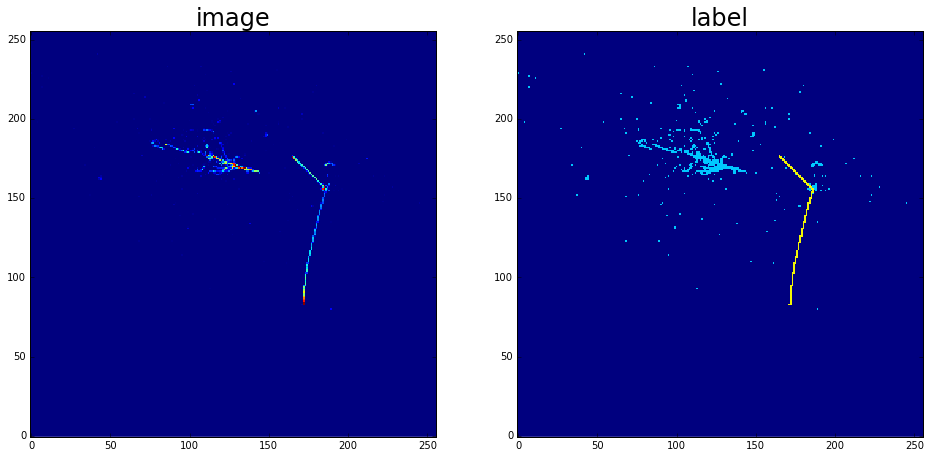

In [ ]:
ENTRY=2
def get_entry(entry):
    # image
    chain_image2d = ROOT.TChain("image2d_data_tree")
    chain_image2d.AddFile('test_10k.root')
    chain_image2d.GetEntry(entry)
    cpp_image2d = chain_image2d.image2d_data_branch.as_vector().front()
    # label
    chain_label2d = ROOT.TChain("image2d_segment_tree")
    chain_label2d.AddFile('test_10k.root')
    chain_label2d.GetEntry(entry)
    cpp_label2d = chain_label2d.image2d_segment_branch.as_vector().front()    
    return (np.array(larcv.as_ndarray(cpp_image2d)), np.array(larcv.as_ndarray(cpp_label2d)))

image2d, label2d = get_entry(ENTRY)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,8), facecolor='w')
ax0.imshow(image2d, interpolation='none', cmap='jet', vmin=0, vmax=1000, origin='lower')
ax0.set_title('image',fontsize=24)
ax1.imshow(label2d, interpolation='none', cmap='jet', vmin=0, vmax=3.1, origin='lower')
ax1.set_title('label',fontsize=24)
plt.show()

On the left, you see the input data image. On the right is the _label_, an answer that our algorithm is supposed to generate. This is the same image frequently reffered to when we [browsed the file contents](http://deeplearnphysics.org/Blog/2018-01-01-BrowsingSegmentationData_v0.1.0.html), the event with 2 protons and 2 gamma rays. During the network training, we will periodically run the network to analyze this event image. 

In order to add this small task, we write a simple training loop below by ourselves instead of using a prepared `batch_process` function (of u-resnet). We will analyze the above image at certain steps defined in `image_dump_steps` below.

If you want to jump to the results of the training, [click here](#train_result).

Image dump @ iteration 20


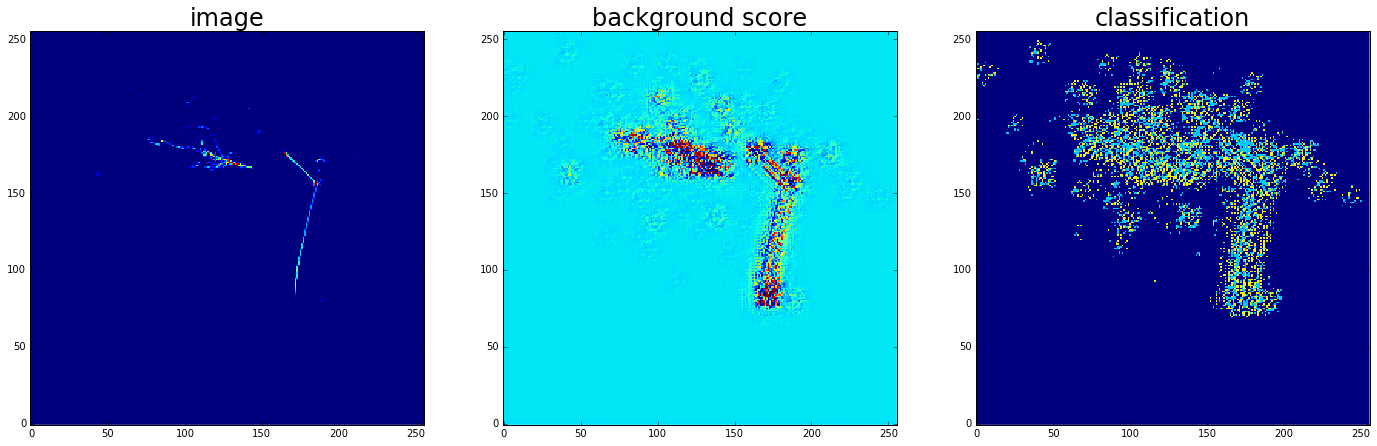

Image dump @ iteration 40


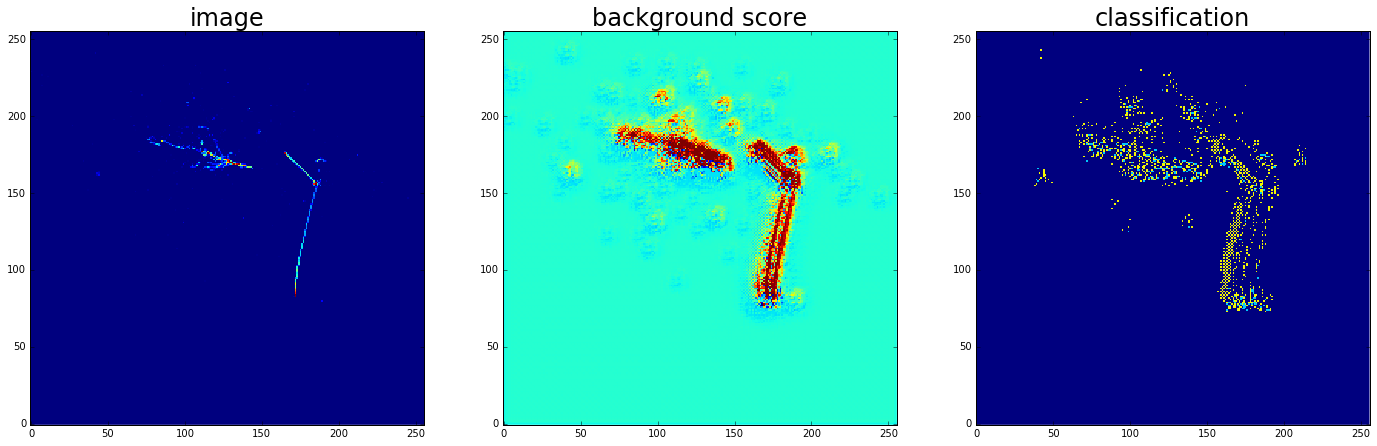

Image dump @ iteration 60


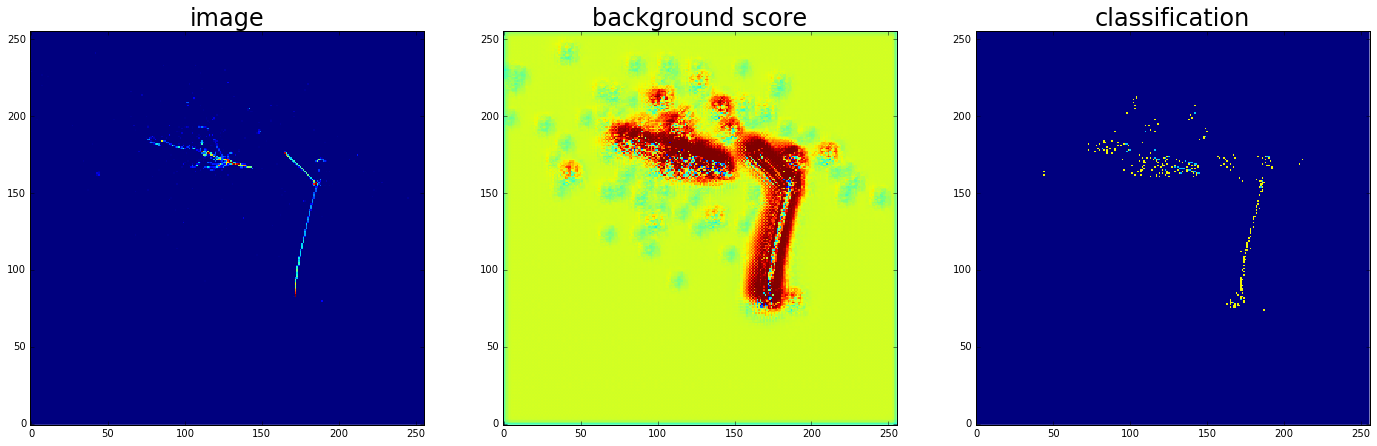

Image dump @ iteration 80


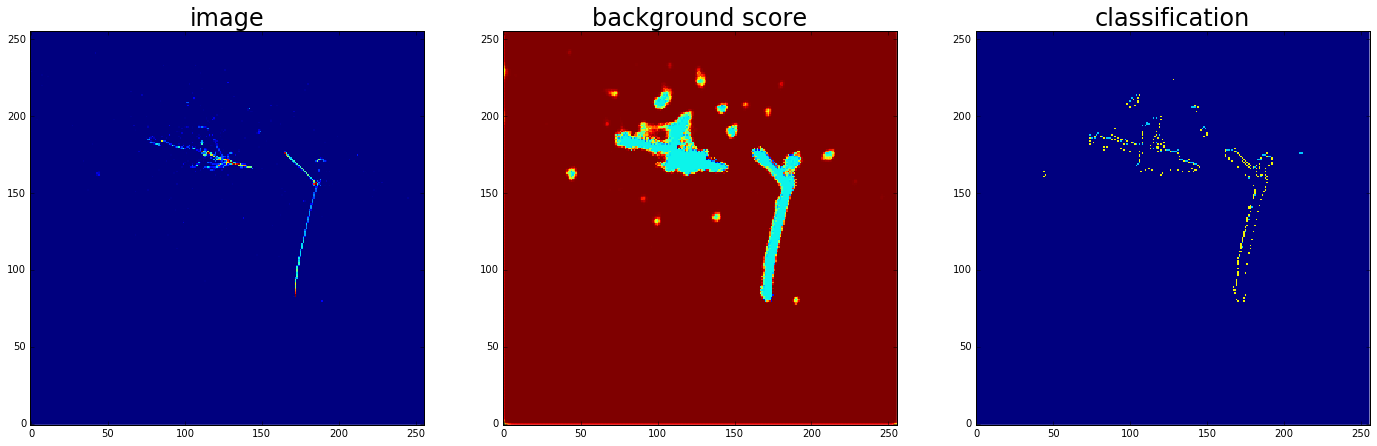

saved @ ssnet_checkpoint/uresnet-100
Image dump @ iteration 100


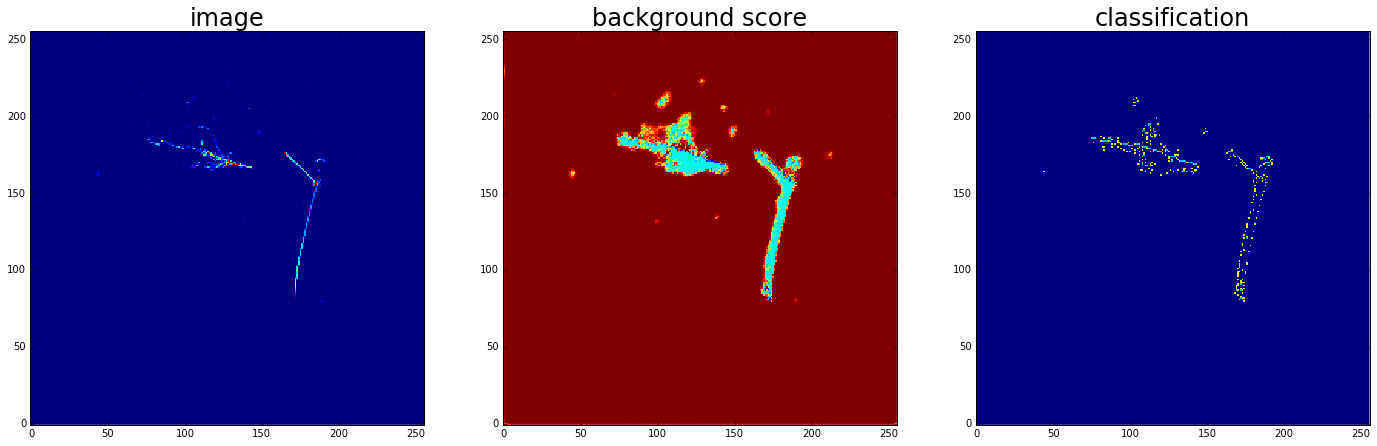

@ iteration 200
Train set: loss=1716.585449   acc. all=0.991888   acc. nonzero=0.098823   
Test set: loss=1186.800781   acc. all=0.994053   acc. nonzero=0.096482   
saved @ ssnet_checkpoint/uresnet-200
Image dump @ iteration 200


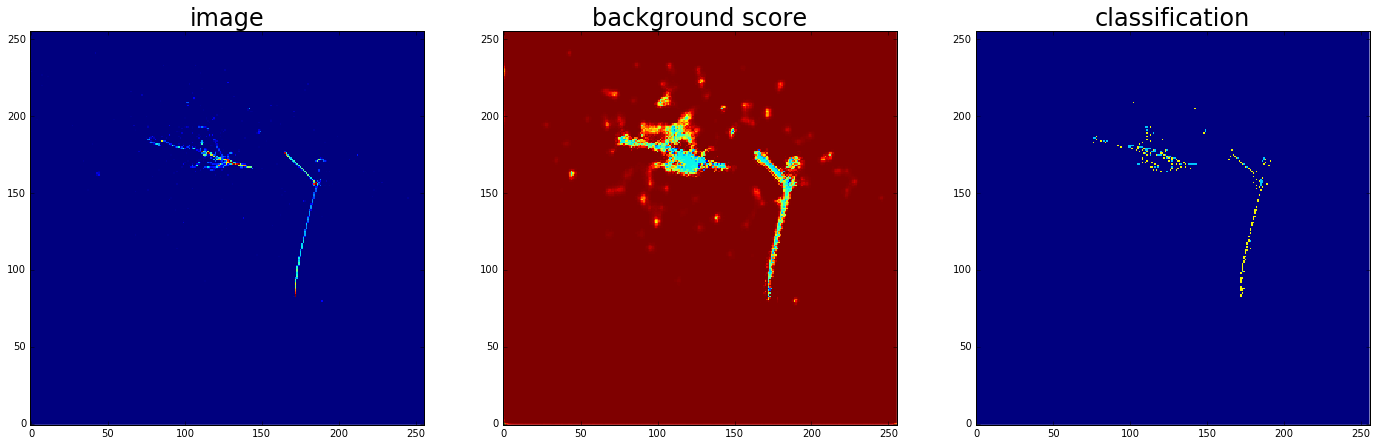

saved @ ssnet_checkpoint/uresnet-300
Image dump @ iteration 300


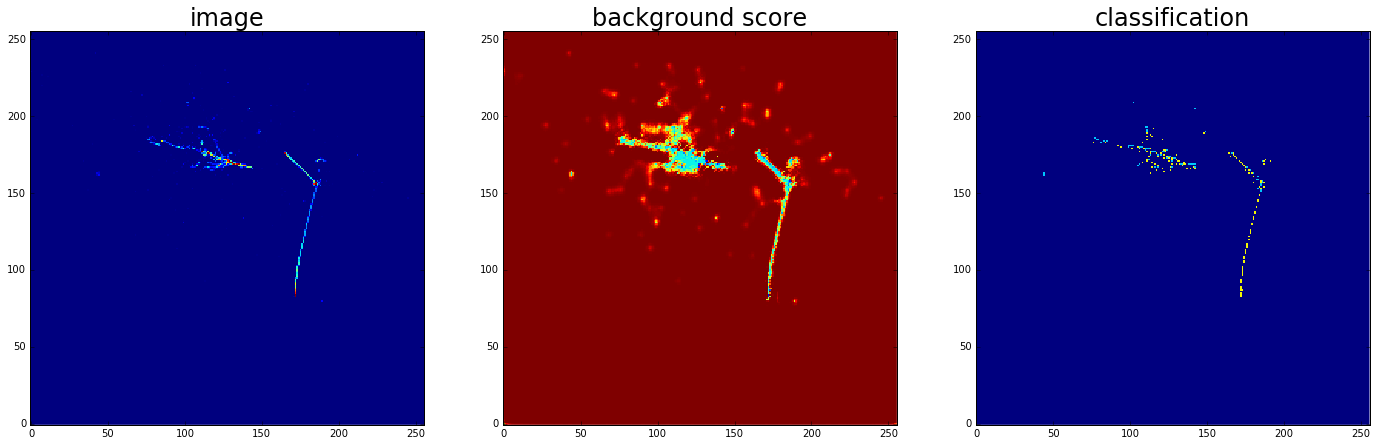

@ iteration 400
Train set: loss=1704.628906   acc. all=0.990824   acc. nonzero=0.116905   
Test set: loss=1576.977783   acc. all=0.991348   acc. nonzero=0.126500   
saved @ ssnet_checkpoint/uresnet-400
Image dump @ iteration 400


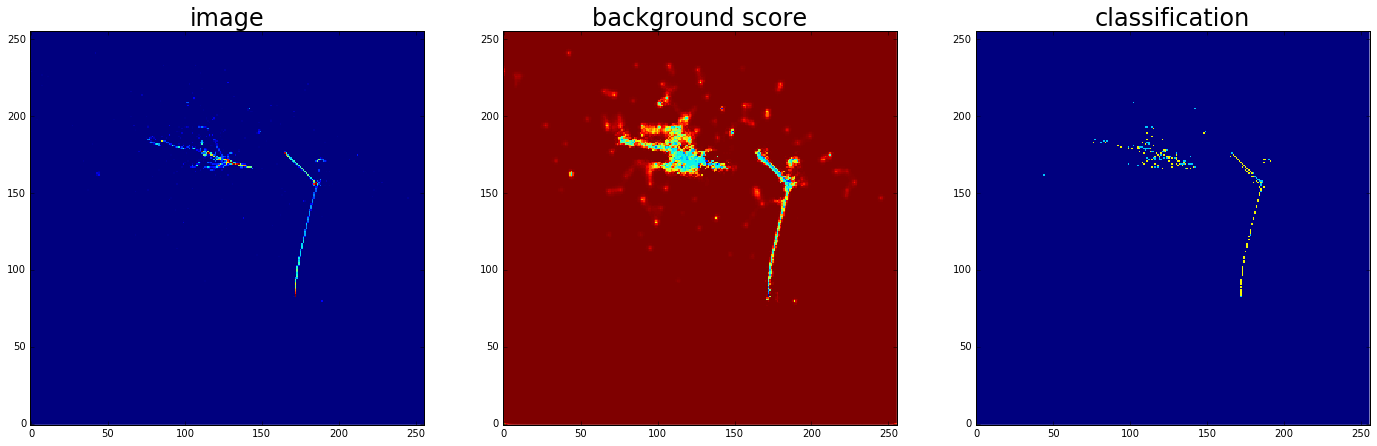

saved @ ssnet_checkpoint/uresnet-500
@ iteration 600
Train set: loss=1089.086426   acc. all=0.993586   acc. nonzero=0.144060   
Test set: loss=1231.338867   acc. all=0.992651   acc. nonzero=0.182390   
saved @ ssnet_checkpoint/uresnet-600
Image dump @ iteration 600


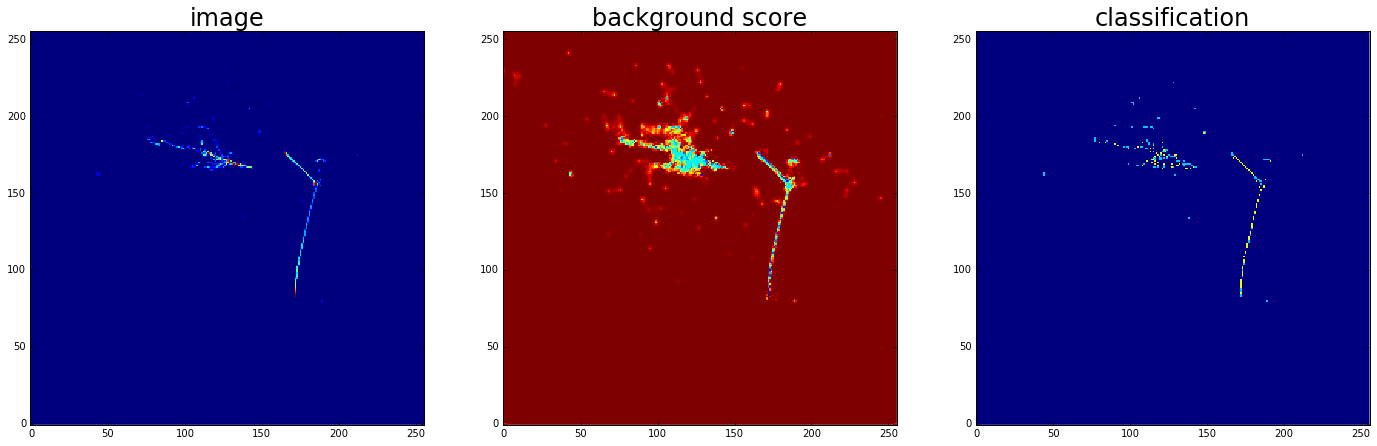

saved @ ssnet_checkpoint/uresnet-700
@ iteration 800
Train set: loss=870.101807   acc. all=0.994499   acc. nonzero=0.197649   
Test set: loss=971.724487   acc. all=0.994194   acc. nonzero=0.231123   
saved @ ssnet_checkpoint/uresnet-800
Image dump @ iteration 800


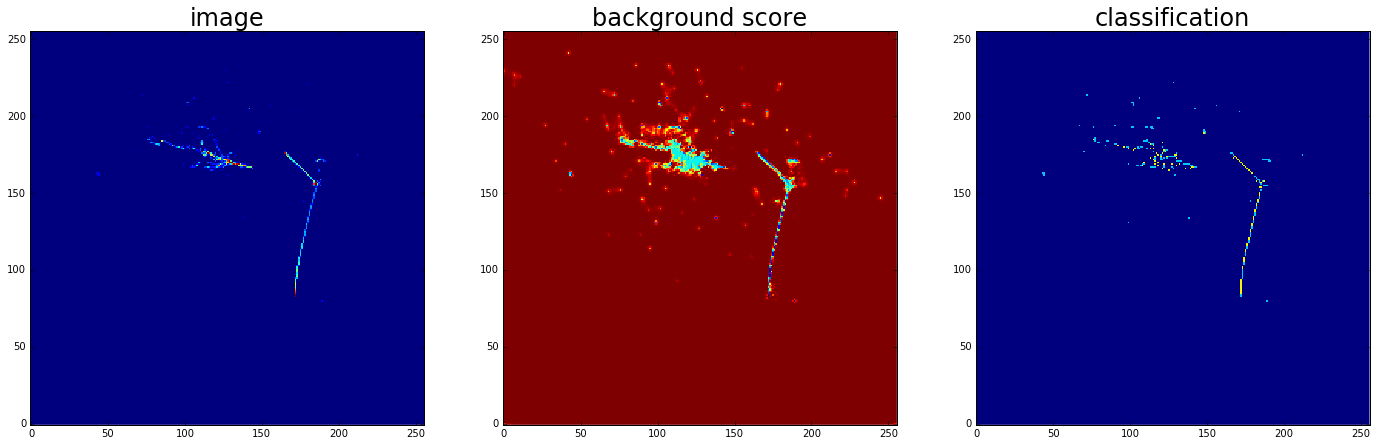

saved @ ssnet_checkpoint/uresnet-900
@ iteration 1000
Train set: loss=791.630127   acc. all=0.995163   acc. nonzero=0.277875   
Test set: loss=1155.722412   acc. all=0.993097   acc. nonzero=0.306119   
saved @ ssnet_checkpoint/uresnet-1000
Image dump @ iteration 1000


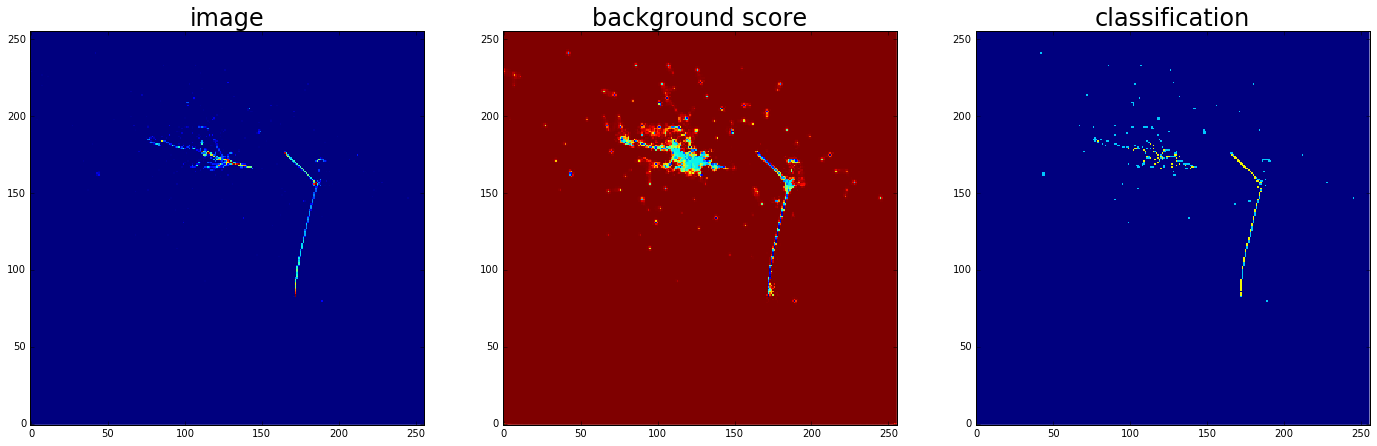

saved @ ssnet_checkpoint/uresnet-1100
@ iteration 1200
Train set: loss=926.961670   acc. all=0.994331   acc. nonzero=0.367506   
Test set: loss=935.218201   acc. all=0.994130   acc. nonzero=0.362160   
saved @ ssnet_checkpoint/uresnet-1200
saved @ ssnet_checkpoint/uresnet-1300
@ iteration 1400
Train set: loss=725.397339   acc. all=0.995700   acc. nonzero=0.461138   
Test set: loss=811.109619   acc. all=0.995306   acc. nonzero=0.472196   
saved @ ssnet_checkpoint/uresnet-1400
saved @ ssnet_checkpoint/uresnet-1500
Image dump @ iteration 1500


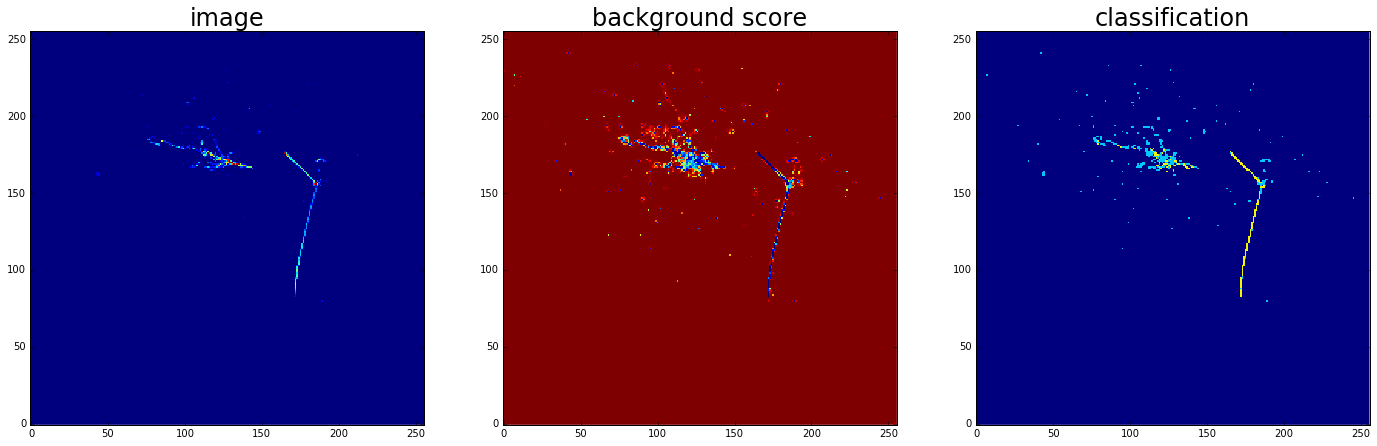

@ iteration 1600
Train set: loss=605.487183   acc. all=0.996844   acc. nonzero=0.603448   
Test set: loss=870.336060   acc. all=0.995335   acc. nonzero=0.601797   
saved @ ssnet_checkpoint/uresnet-1600
saved @ ssnet_checkpoint/uresnet-1700
@ iteration 1800
Train set: loss=515.539001   acc. all=0.997294   acc. nonzero=0.692784   
Test set: loss=426.922424   acc. all=0.997761   acc. nonzero=0.697013   
saved @ ssnet_checkpoint/uresnet-1800
saved @ ssnet_checkpoint/uresnet-1900
@ iteration 2000
Train set: loss=388.664246   acc. all=0.997895   acc. nonzero=0.754325   
Test set: loss=616.177551   acc. all=0.996823   acc. nonzero=0.775275   
saved @ ssnet_checkpoint/uresnet-2000
Image dump @ iteration 2000


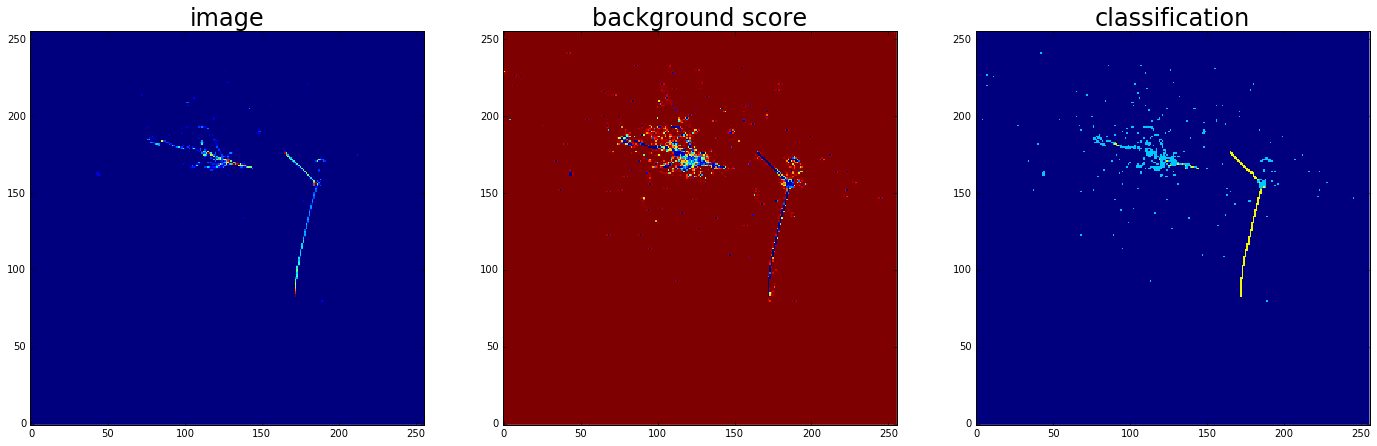

saved @ ssnet_checkpoint/uresnet-2100
@ iteration 2200
Train set: loss=542.351746   acc. all=0.997132   acc. nonzero=0.768909   
Test set: loss=267.379333   acc. all=0.998564   acc. nonzero=0.780359   
saved @ ssnet_checkpoint/uresnet-2200
saved @ ssnet_checkpoint/uresnet-2300
@ iteration 2400
Train set: loss=530.541504   acc. all=0.997191   acc. nonzero=0.789259   
Test set: loss=288.715942   acc. all=0.998500   acc. nonzero=0.823314   
saved @ ssnet_checkpoint/uresnet-2400
saved @ ssnet_checkpoint/uresnet-2500
Image dump @ iteration 2500


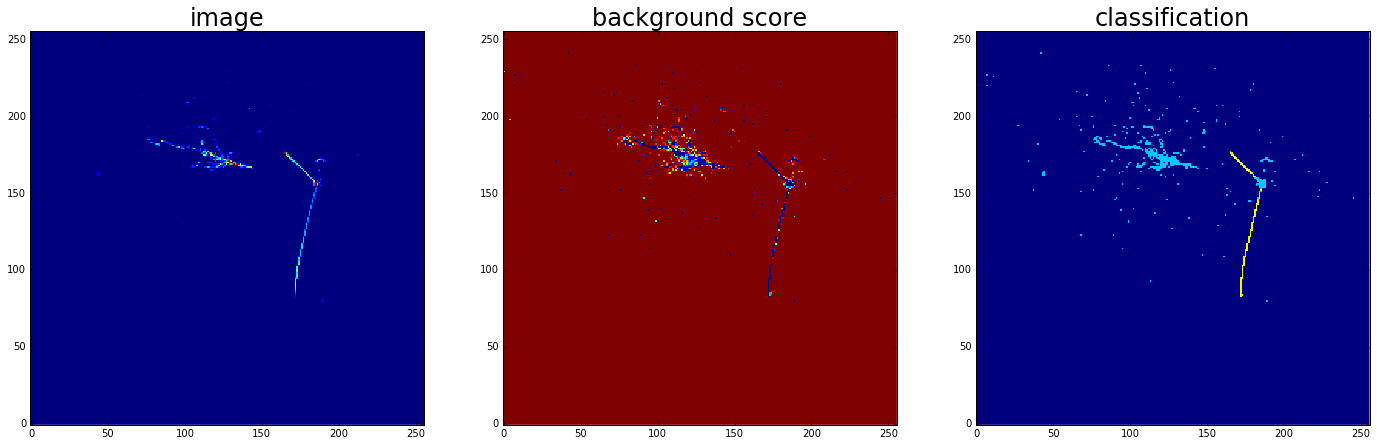

@ iteration 2600
Train set: loss=389.280029   acc. all=0.997963   acc. nonzero=0.813510   
Test set: loss=297.563995   acc. all=0.998393   acc. nonzero=0.823515   
saved @ ssnet_checkpoint/uresnet-2600
saved @ ssnet_checkpoint/uresnet-2700
@ iteration 2800
Train set: loss=248.452744   acc. all=0.998657   acc. nonzero=0.800813   
Test set: loss=336.084808   acc. all=0.998242   acc. nonzero=0.808636   
saved @ ssnet_checkpoint/uresnet-2800
saved @ ssnet_checkpoint/uresnet-2900
@ iteration 3000
Train set: loss=342.867188   acc. all=0.998108   acc. nonzero=0.873186   
Test set: loss=486.885345   acc. all=0.997252   acc. nonzero=0.792564   
saved @ ssnet_checkpoint/uresnet-3000
Image dump @ iteration 3000


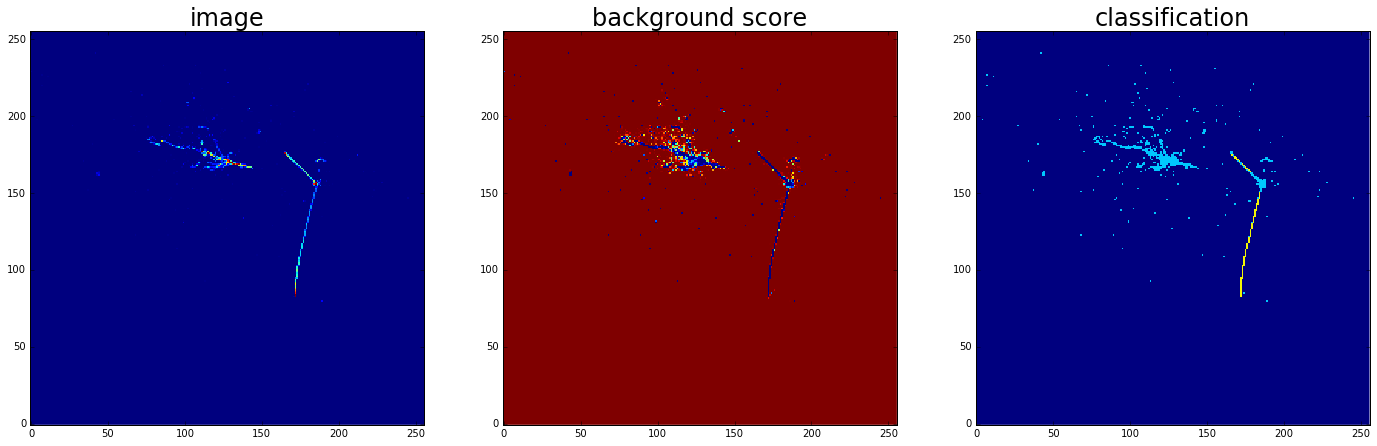

saved @ ssnet_checkpoint/uresnet-3100
@ iteration 3200
Train set: loss=324.946045   acc. all=0.998202   acc. nonzero=0.827179   
Test set: loss=274.677582   acc. all=0.998577   acc. nonzero=0.792074   
saved @ ssnet_checkpoint/uresnet-3200
saved @ ssnet_checkpoint/uresnet-3300
@ iteration 3400
Train set: loss=307.326385   acc. all=0.998311   acc. nonzero=0.840922   
Test set: loss=413.127045   acc. all=0.997766   acc. nonzero=0.811417   
saved @ ssnet_checkpoint/uresnet-3400
saved @ ssnet_checkpoint/uresnet-3500
Image dump @ iteration 3500


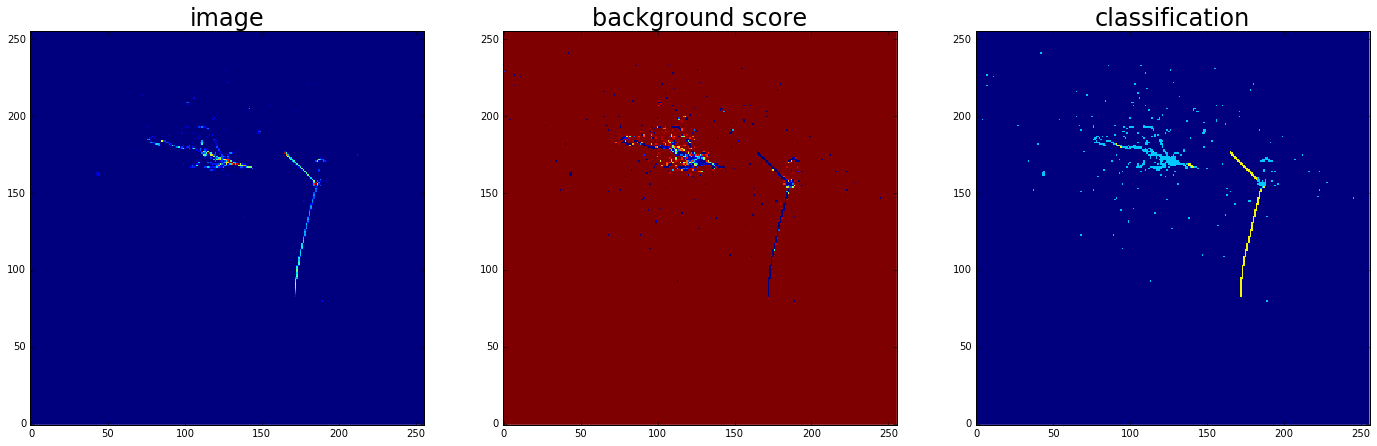

@ iteration 3600
Train set: loss=337.157562   acc. all=0.998215   acc. nonzero=0.838107   
Test set: loss=238.478241   acc. all=0.998682   acc. nonzero=0.807182   
saved @ ssnet_checkpoint/uresnet-3600
saved @ ssnet_checkpoint/uresnet-3700
@ iteration 3800
Train set: loss=216.171295   acc. all=0.998754   acc. nonzero=0.884419   
Test set: loss=211.169891   acc. all=0.998744   acc. nonzero=0.836277   
saved @ ssnet_checkpoint/uresnet-3800
saved @ ssnet_checkpoint/uresnet-3900
@ iteration 4000
Train set: loss=291.283142   acc. all=0.998416   acc. nonzero=0.839142   
Test set: loss=206.065262   acc. all=0.998871   acc. nonzero=0.873705   
saved @ ssnet_checkpoint/uresnet-4000
Image dump @ iteration 4000


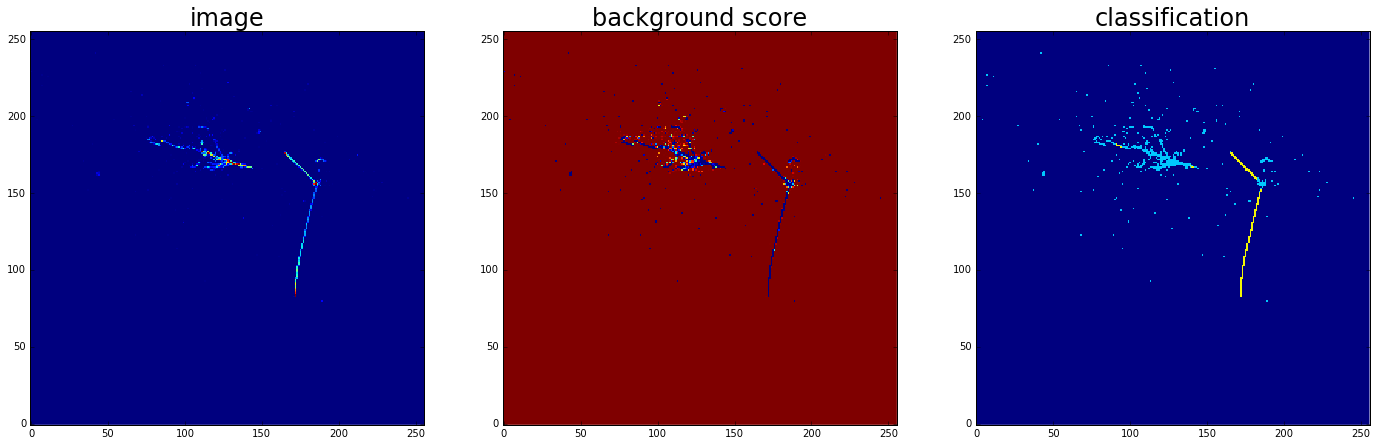

saved @ ssnet_checkpoint/uresnet-4100
@ iteration 4200
Train set: loss=204.747833   acc. all=0.998909   acc. nonzero=0.882854   
Test set: loss=235.429367   acc. all=0.998720   acc. nonzero=0.862495   
saved @ ssnet_checkpoint/uresnet-4200
saved @ ssnet_checkpoint/uresnet-4300
@ iteration 4400
Train set: loss=211.862183   acc. all=0.998851   acc. nonzero=0.893884   
Test set: loss=227.270081   acc. all=0.998819   acc. nonzero=0.897133   
saved @ ssnet_checkpoint/uresnet-4400
saved @ ssnet_checkpoint/uresnet-4500
Image dump @ iteration 4500


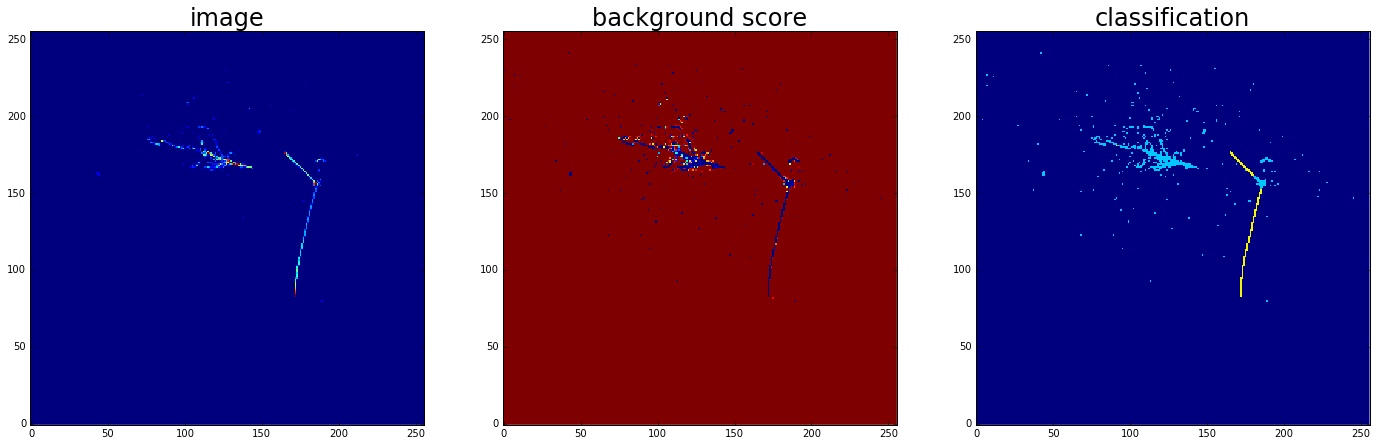

@ iteration 4600
Train set: loss=250.857834   acc. all=0.998696   acc. nonzero=0.899529   
Test set: loss=244.141510   acc. all=0.998770   acc. nonzero=0.901782   
saved @ ssnet_checkpoint/uresnet-4600
saved @ ssnet_checkpoint/uresnet-4700
@ iteration 4800
Train set: loss=155.150391   acc. all=0.999157   acc. nonzero=0.899054   
Test set: loss=135.839294   acc. all=0.999239   acc. nonzero=0.906230   
saved @ ssnet_checkpoint/uresnet-4800
saved @ ssnet_checkpoint/uresnet-4900
@ iteration 5000
Train set: loss=173.586670   acc. all=0.999095   acc. nonzero=0.893939   
Test set: loss=172.795837   acc. all=0.999103   acc. nonzero=0.906439   
saved @ ssnet_checkpoint/uresnet-5000
Image dump @ iteration 5000


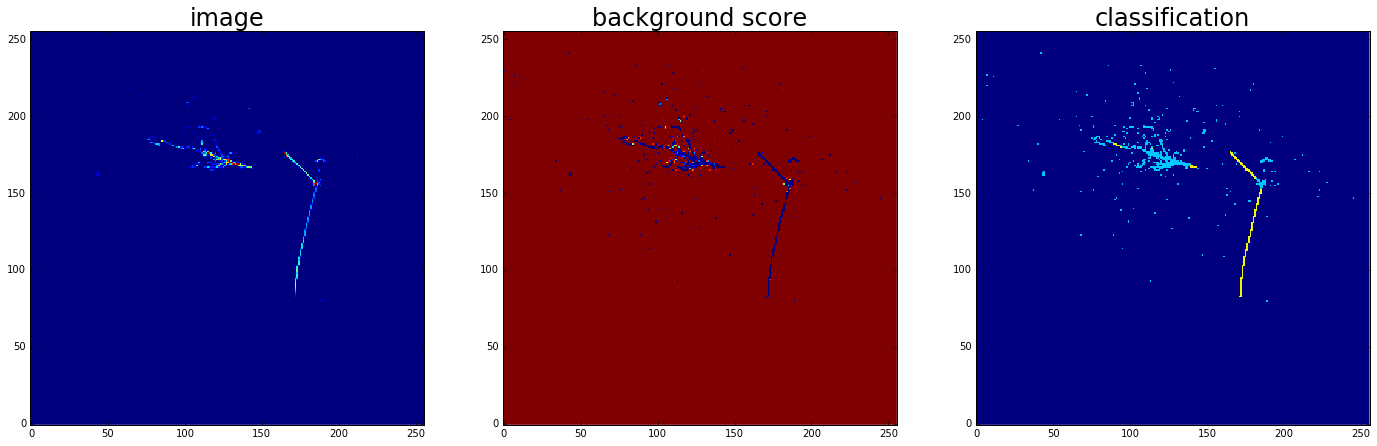

saved @ ssnet_checkpoint/uresnet-5100
@ iteration 5200
Train set: loss=138.855255   acc. all=0.999206   acc. nonzero=0.907051   
Test set: loss=101.364075   acc. all=0.999422   acc. nonzero=0.922535   
saved @ ssnet_checkpoint/uresnet-5200
saved @ ssnet_checkpoint/uresnet-5300
@ iteration 5400
Train set: loss=100.466881   acc. all=0.999470   acc. nonzero=0.930668   
Test set: loss=122.729141   acc. all=0.999338   acc. nonzero=0.911455   
saved @ ssnet_checkpoint/uresnet-5400
saved @ ssnet_checkpoint/uresnet-5500
Image dump @ iteration 5500


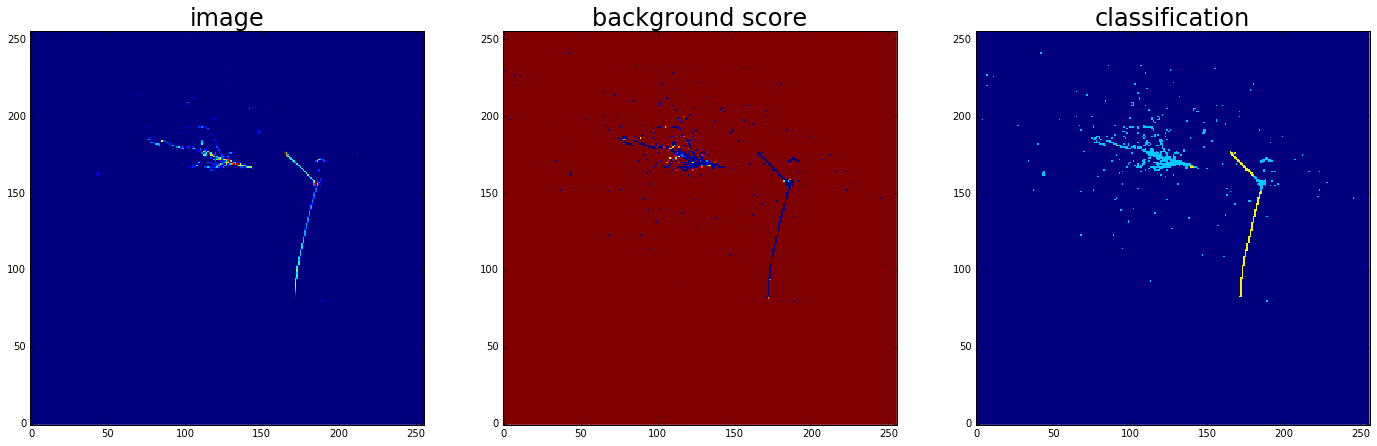

@ iteration 5600
Train set: loss=112.448235   acc. all=0.999382   acc. nonzero=0.931766   
Test set: loss=94.699997   acc. all=0.999464   acc. nonzero=0.936889   
saved @ ssnet_checkpoint/uresnet-5600
saved @ ssnet_checkpoint/uresnet-5700
@ iteration 5800
Train set: loss=107.878113   acc. all=0.999455   acc. nonzero=0.929338   
Test set: loss=103.014931   acc. all=0.999405   acc. nonzero=0.922290   
saved @ ssnet_checkpoint/uresnet-5800
saved @ ssnet_checkpoint/uresnet-5900
@ iteration 6000
Train set: loss=120.477577   acc. all=0.999314   acc. nonzero=0.913737   
Test set: loss=71.752052   acc. all=0.999613   acc. nonzero=0.929779   
saved @ ssnet_checkpoint/uresnet-6000
Image dump @ iteration 6000


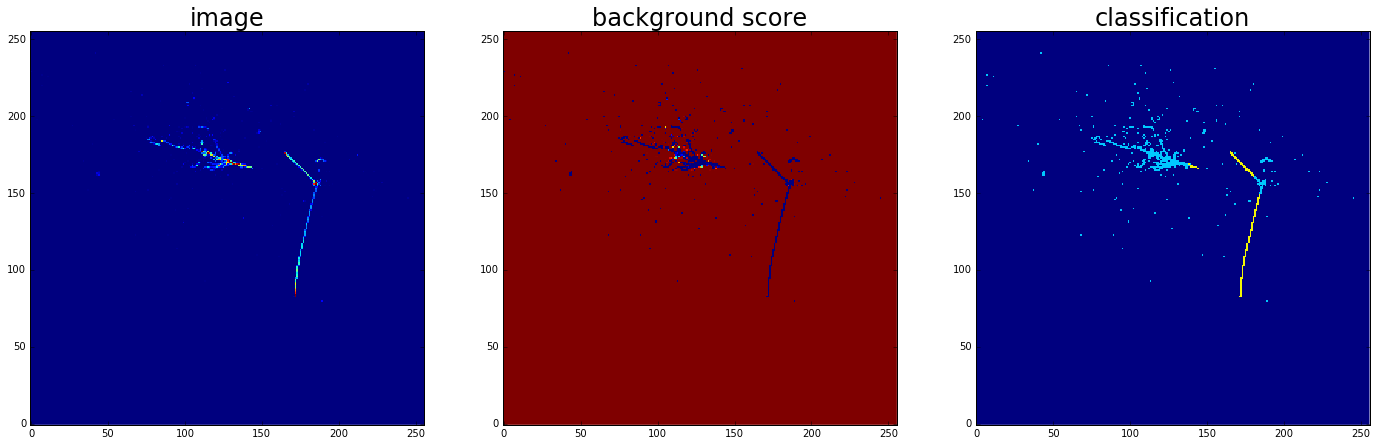

saved @ ssnet_checkpoint/uresnet-6100
@ iteration 6200
Train set: loss=135.373901   acc. all=0.999297   acc. nonzero=0.922565   
Test set: loss=130.732056   acc. all=0.999211   acc. nonzero=0.886985   
saved @ ssnet_checkpoint/uresnet-6200
saved @ ssnet_checkpoint/uresnet-6300
@ iteration 6400
Train set: loss=91.569870   acc. all=0.999467   acc. nonzero=0.937483   
Test set: loss=92.116501   acc. all=0.999533   acc. nonzero=0.940604   
saved @ ssnet_checkpoint/uresnet-6400
saved @ ssnet_checkpoint/uresnet-6500
Image dump @ iteration 6500


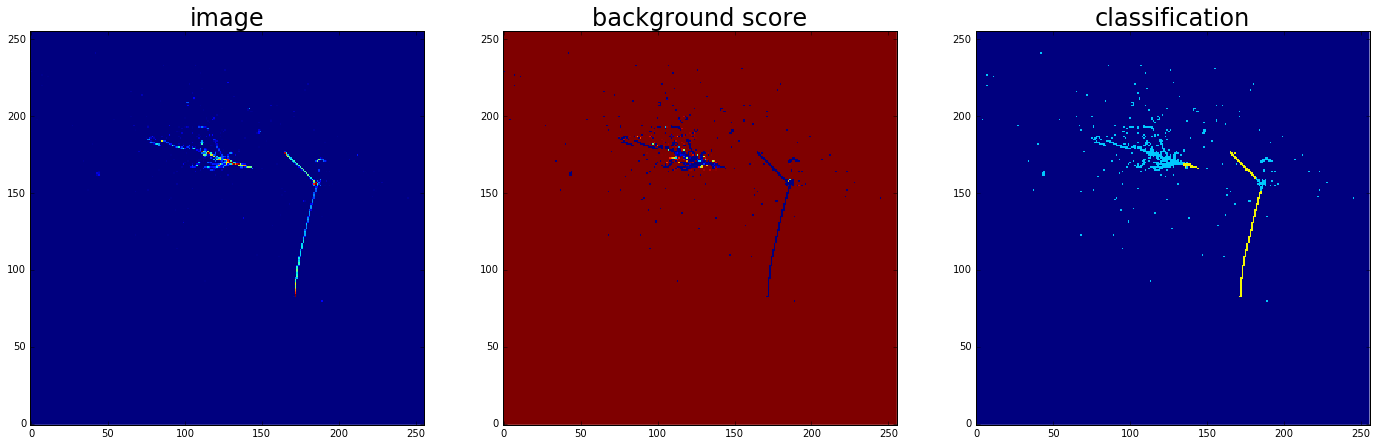

@ iteration 6600
Train set: loss=132.184723   acc. all=0.999305   acc. nonzero=0.922289   
Test set: loss=87.055489   acc. all=0.999458   acc. nonzero=0.894165   
saved @ ssnet_checkpoint/uresnet-6600
saved @ ssnet_checkpoint/uresnet-6700
@ iteration 6800
Train set: loss=67.098053   acc. all=0.999605   acc. nonzero=0.952096   
Test set: loss=71.518471   acc. all=0.999518   acc. nonzero=0.937674   
saved @ ssnet_checkpoint/uresnet-6800
saved @ ssnet_checkpoint/uresnet-6900
@ iteration 7000
Train set: loss=88.592003   acc. all=0.999491   acc. nonzero=0.933244   
Test set: loss=79.800659   acc. all=0.999573   acc. nonzero=0.951704   
saved @ ssnet_checkpoint/uresnet-7000
Image dump @ iteration 7000


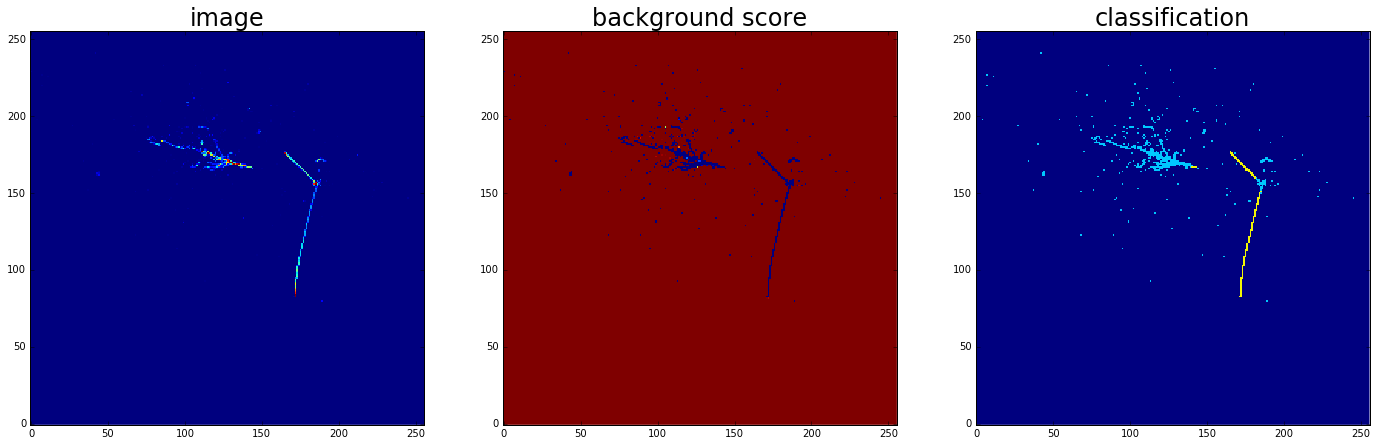

saved @ ssnet_checkpoint/uresnet-7100
@ iteration 7200
Train set: loss=101.933014   acc. all=0.999425   acc. nonzero=0.927749   
Test set: loss=129.239105   acc. all=0.999359   acc. nonzero=0.901681   
saved @ ssnet_checkpoint/uresnet-7200
saved @ ssnet_checkpoint/uresnet-7300
@ iteration 7400
Train set: loss=66.202988   acc. all=0.999600   acc. nonzero=0.940409   
Test set: loss=63.866642   acc. all=0.999694   acc. nonzero=0.964605   
saved @ ssnet_checkpoint/uresnet-7400
saved @ ssnet_checkpoint/uresnet-7500
Image dump @ iteration 7500


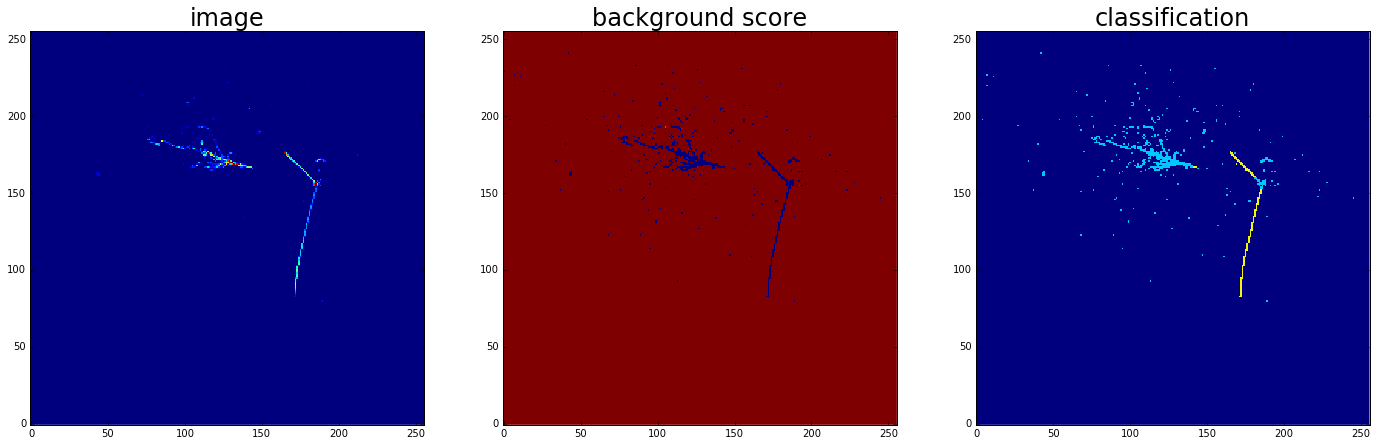

@ iteration 7600
Train set: loss=94.409027   acc. all=0.999462   acc. nonzero=0.935092   
Test set: loss=89.532578   acc. all=0.999568   acc. nonzero=0.919580   
saved @ ssnet_checkpoint/uresnet-7600
saved @ ssnet_checkpoint/uresnet-7700


In [ ]:
input_shape  = [1,image2d.size]
image_data = np.array(image2d).reshape(input_shape)

image_dump_steps = np.concatenate((np.arange(0,100,20), 
                                   np.arange(100,400,100), 
                                   np.arange(400,1000,200), 
                                   np.arange(1000,20000,500))).astype(np.int32)

while t.current_iteration() < t.iterations():
    t.train_step()
    if t.current_iteration() in image_dump_steps:
        print('Image dump @ iteration {:d}'.format(t.current_iteration()))
        
        softmax, = t.ana(input_data = image_data)
        fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(24,8), facecolor='w')
        # image
        ax0.imshow(image2d, interpolation='none', cmap='jet', vmin=0, vmax=1000, origin='lower')
        ax0.set_title('image',fontsize=24)
        
        ax1.imshow(softmax[0,:,:,0], interpolation='none', cmap='jet', vmin=0, vmax=1.0, origin='lower')
        ax1.set_title('background score',fontsize=24)
        
        ax2.imshow(softmax[0].argmax(axis=2), interpolation='none', cmap='jet', vmin=0., vmax=3.1, origin='lower')
        ax2.set_title('classification', fontsize=24)
        plt.savefig('iteration_{:04d}.png'.format(t.current_iteration()))
        plt.show()
        plt.close()


<a name="train_result"></a>
## Training Results
**Phew that was long!** Lots of dumped image/text. It took nearly 2 hours using an old generation (maxwell) [Titan X](https://www.inet.se/files/pdf/5411391_0.pdf) GPU on my box. If you jumped here from much earlier part of this note book, I made a gif animation of the dumped "test images" for us to see the network's learning progress visually.

<img src="imgs/2018-01-05-TrainingSegmentationData_v0.1.0/animated.gif" alt="Animated">

###  A few clarifications
* **<font color="red">How is "loss" defined?</font>**
    * In one image, u-resnet calculates the softmax (multinominal regression) loss for 3 category classification. Then the loss is added for all pixels in the image, and averaged over all images in one batch. So it is essentially an average of all-pixel-softmax-sum. If you expected loss value to be smaller (like _o_(1)), the reason why is because this is a linear sum of _many_ softmax loss (i.e. all pixels in an image).
* **<font color="red">What is "acc. all"?</font>**
    * It is a fraction of pixels that the network classified correctly. The network's prediction is a simple _argmax_ of the softmax score per pixel. Then the accuracy is computed per image by counting number of correctly classified pixels divided by total pixel count in an image. Finally we average the accuracy over the images in the batch. We expect this to be _very high_ because the majority of pixels are backgrounds in LArTPC images. By simply guessing all pixels are backgrounds, you can actually get >99% accuracy!
* **<font color="red">What is "acc. nonzero"?</font>**
    * This is same as "acc. all" except it is only computed for pixels for which the label is not background (hence the name, nonzero accuracy). This is actually what we care the most.
    
### Visualizing logs
Below you find the tensorboard visualization of all three parameters during the training. Data points are stored every 20 iterations (see [u-resnet configuration](#config_uresnet) section).
<img src="imgs/2018-01-05-TrainingSegmentationData_v0.1.0/tb_accuracy_all.png" alt="TensorBoard All Pixel Accuracy">
<img src="imgs/2018-01-05-TrainingSegmentationData_v0.1.0/tb_accuracy_nonzero.png" alt="TensorBoard Nonzero Pixel Accuracy">
<img src="imgs/2018-01-05-TrainingSegmentationData_v0.1.0/tb_loss.png" alt="TensorBoard All Pixel Loss">

### A few observations:
* **<font color="blue">Learning the backgrounds</font>**
    * U-ResNet quickly learned about the most abandoned category, the _background_ pixels.
    * The network first learned 0-pixels being background. We can see the "background score" of the sample image is becoming dark-red quickly. This means the network has become very confident on those 0-pixels being backgrounds.
    * Going over 1000 iterations, the network learned to draw more and more accurate boundary. An initially fuzzy cyan color "island" of non-zero pixels (i.e. non-background pixels) has finally became non-fuzzy dark blue pixels toward the end.
* **<font color="blue">Learning particle features</font>**
    * We can see, clearly, the network is learning more than background vs. non-background. The track (yellow) vs. shower (cyan) classification has become quite accurate toward the final iteration.
    * The beginning of gamma ray shower, a short track-like straight trajectory segment with high dE/dX, appears to be particularly a hard thing to classify. We can see both struggle and improvement in the training.
    


<a name="uresnet_brief"></a>
## Extra: a bit more about U-ResNet 
I add a few abstract/qualitative descriptions about U-ResNet. This network design is not from us (MicroBooNE). All we did is to combine two novel network designs: [U-Net](https://arxiv.org/abs/1505.04597) to attack the semantic segmentation task, and [ResNet](https://arxiv.org/abs/1512.03385) to improve the internal convolution layers. You can find tensorboard graph for the u-resnet below.

<img src="imgs/2018-01-05-TrainingSegmentationData_v0.1.0/uresnet_graph.png" alt="U-ResNet Graph">

###  Why U-Net?
A typical convolutional neural network design for image classification involves down-sampling of an image to expand the receptive field of a neuron at deeper layers, hoping for it to learn a large (abstract) fetures. A typical semantic segmentation network contains the same design but with an additional portion which performs convolution-transpose to expand the contracted feature map size back to the size of the original input. 

A problem in this scheme is the fact that down sampling would lose spatial resolution. In order to overcome this issue, U-Net added an information flow-path between the convolution and convolution-transpose layers by simply concatenating the feature maps. By doing this, neurons at deeper layers can always recover the best possible spatial resolution information. 

We used **ResNet** in the place of a standard convolution operations of the original U-Net for the exact reason ResNet was invented for: it is suited to train deep nets and it learns well. Both ResNet and U-Net follows a similar design pattern by adding more paaths for information to flow, and neurons to learn the perturbations.
